<b>Part 1 - Exploratory Data Analysis</b><br>
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [8]:
import os
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import json
import matplotlib.pylab as plt
import statsmodels as sm

%matplotlib inline


In [9]:
#read data
logins = pd.read_json('data/logins.json')
df = pd.DataFrame(logins)
df.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [10]:
df.login_time = pd.to_datetime(df.login_time)#convert to datetime object
df.index = (df.login_time) # set datetime as index
df['login'] = 1 #count each observation as an instance

In [11]:
df_15 = pd.DataFrame(df.login.resample('15Min').sum()) #aggregate as the sum of instances over 15 min
df_15 = df_15.fillna(0) #fill missing values as zero to indicate no logins during that interval

In [12]:
df_15.head()

login
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

After aggregating the login times by 15 min interval, it is time for analysis. We can start by looking at the seasonal breakdown of the data for any patterns

Text(0.5, 1.0, 'total log-ins seasonality')

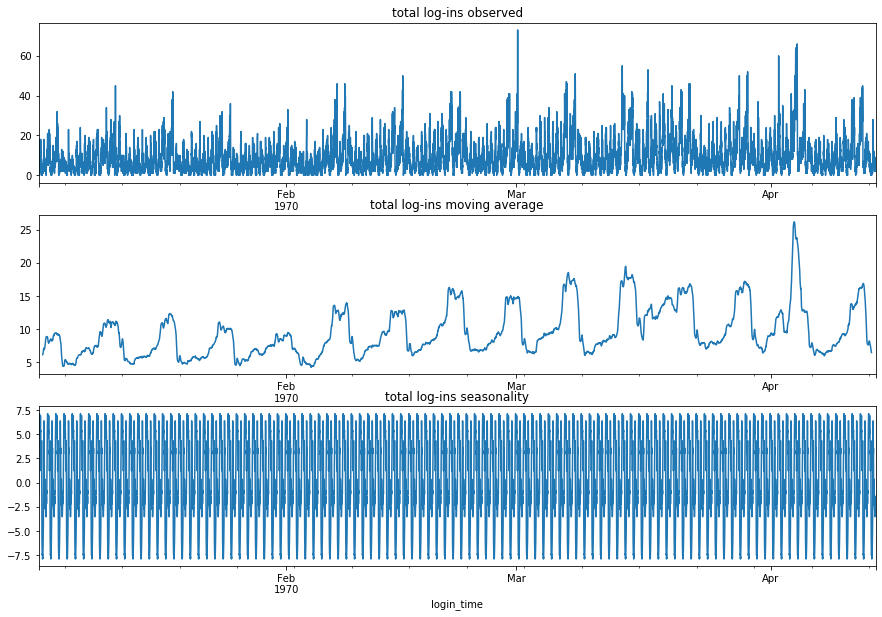

In [13]:
from statsmodels.tsa import seasonal
plt.figure(figsize=(15,10))

#plot
r = sm.tsa.seasonal.seasonal_decompose(df_15.login, model='additive', freq=96)
plt.subplot(3,1,1)
r.observed.plot()
plt.title('total log-ins observed')
plt.subplot(3,1,2)
r.trend.plot()
plt.title('total log-ins moving average')
plt.subplot(3,1,3)
r.seasonal.plot()
plt.title('total log-ins seasonality')

There definitely appears to have a pattern connection to logins. It is difficult to interpret exactly what that connection is, however it is clear that there is a weekly trend occurring that increases over time. The number of logins are increasing overall. To investigate, we should look at daily and weekly patterns more closely.

In [14]:
#average each login by hour of day across all days
daily = df_15.login.groupby(df_15.index.hour).mean()

#average each login by day of week across all weeks
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'] #a list to reindex days as days of week
weekly = df_15.login.groupby(df_15.index.weekday_name).mean().reindex(days)

Text(0.5, 1.0, 'average total log-ins by day of week')

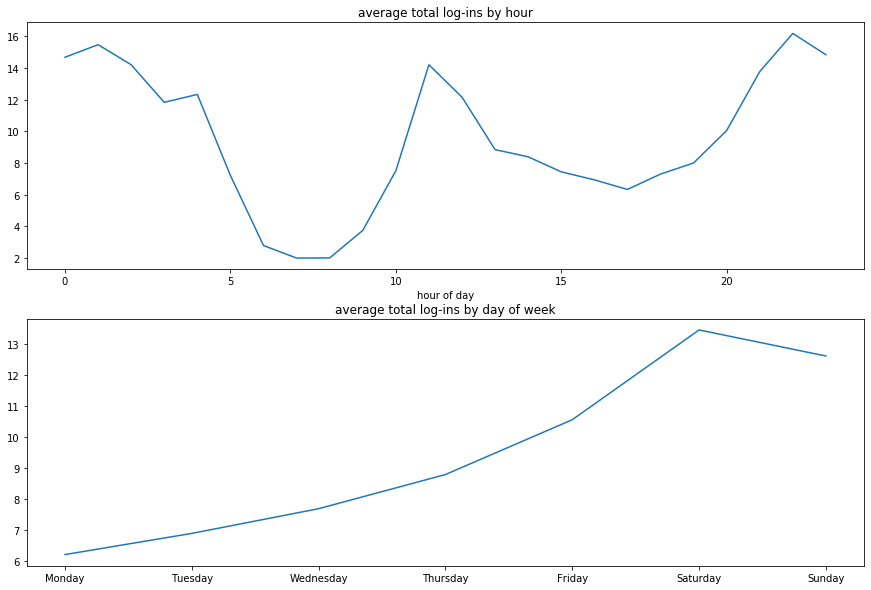

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(daily)
plt.title('average total log-ins by hour')
plt.xlabel('hour of day')
plt.subplot(2,1,2)
plt.plot(weekly.values)
plt.xticks([0,1,2,3,4,5,6], days)
plt.title('average total log-ins by day of week')

For the first graph which depicts average total log ins by hour, we see three distinct peaks. The first one from midnight to 4am. The second peak occurs from 10am-12pm. The third peak occurs around 10pm. This could be correlated to break times that people have during their days, either late at night or during lunch time.

For the second graph which illustrates average log ins by day of the week, the lowest logins begin on Monday and steadily increase from there. The log ins peak on Saturday and begin decreasing on Sunday.

<b>Part 2 ‑ Experiment and metrics design </b><br>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the observation

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

<b>Solution: </b>
<br>
For the key measure of success of this experiment, I would look at the reimbursement costs for the two cities and percentage of reimbursement costs by total tolls costs. If the reimbursement costs increase, then we know that drivers are going to another city. If the percentage of reimbursed tolls over total toll costs increase, then we know that activities between the two cities is increasing. The larger the increase of these reimbursed costs and percentage, the larger the success of the experiment.

I would implement this experiment by collecting driver data such as date, time, direction, reimbursed tolls etc. We would then aggregate the data, plot and observe any trends or patterns that occur. Hopefully we would see a steady increase as this would suggest a successful experiment.

A statistical significance test we could conduct is the t-test, specifically the 2 sample t-test. We could determine a null and alternative hypothesis for the two cities:

Null Hypothesis: Reimbursed toll costs of Ultimate Gotham and Ultimate Metropolis are the same 

Alternative Hypothesis: Reimbursed toll costs of Ultimate Gotham and Ultimate Metropolis are unequal 

After calculating, if the t-statistic is greater than the critical t-value, it is statistically significant and you would reject the null hypothesis and accept the alternative. This would show us where driver activity is occuring and if it leans heavily a certain way.

<b>Part 3 ‐ Predictive modeling</b>
<br>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

<b>Data description</b><br>

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYY MM DD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: the average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

### Data Wrangling

In [17]:
#load libraries
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data
with open('data/ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [20]:

df.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          50000.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.564977      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.500000      1.000000   
50%                  1.000000              4.700000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000  50000.000000          50000.000000  
mean       8.849536     60.926084      5.796827              4.778158  
std       19.958811     37.081503      5.707357              0.445753  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.600000    100.000000      6.940000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

In [21]:

#fill missing values in avg_rating_by_driver and avg_rating_of_driver with mean
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

In [22]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [23]:
# Convert dates to datetime format
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

### Exploratory Data Analysis

In [24]:
# Create box plots of all categorical, non-date data
categorical_features = ['city', 'phone', 'ultimate_black_user']

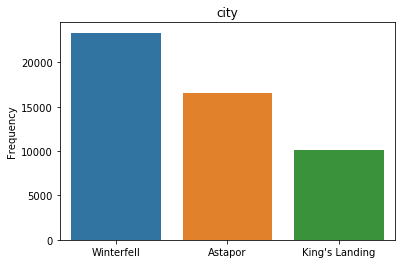

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


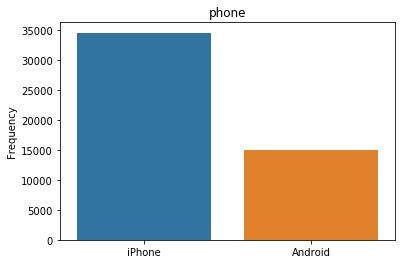

iPhone     34582
Android    15022
Name: phone, dtype: int64


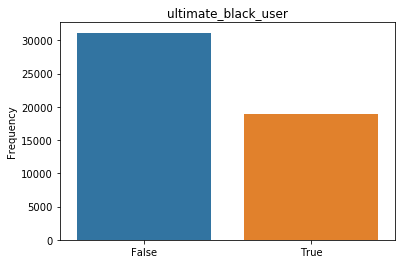

False    31146
True     18854
Name: ultimate_black_user, dtype: int64


In [25]:
for feature in categorical_features:
    sns.barplot(x = list(df[feature].value_counts().index), y = df[feature].value_counts())
    plt.title(feature)
    plt.ylabel('Frequency')
    plt.show()
    print(df[feature].value_counts())

In [26]:
# Show distributions of numerical features
numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

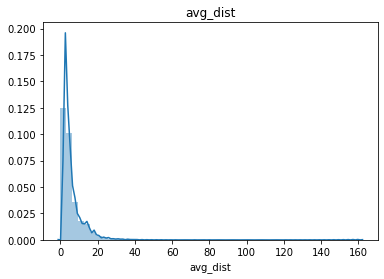

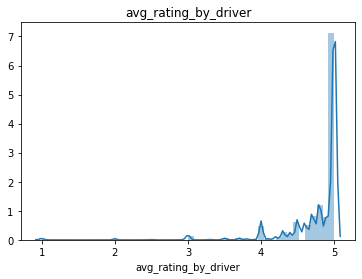

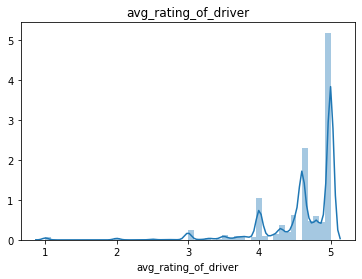

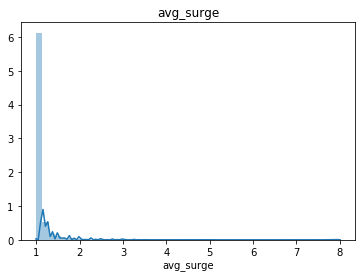

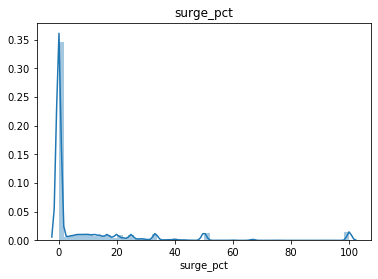

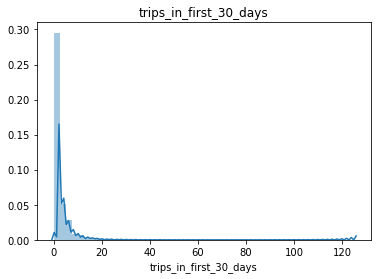

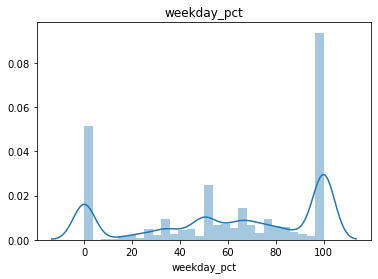

In [27]:
for feature in numerical_features:
    sns.distplot(df[feature])
    plt.title(feature)
    plt.show();

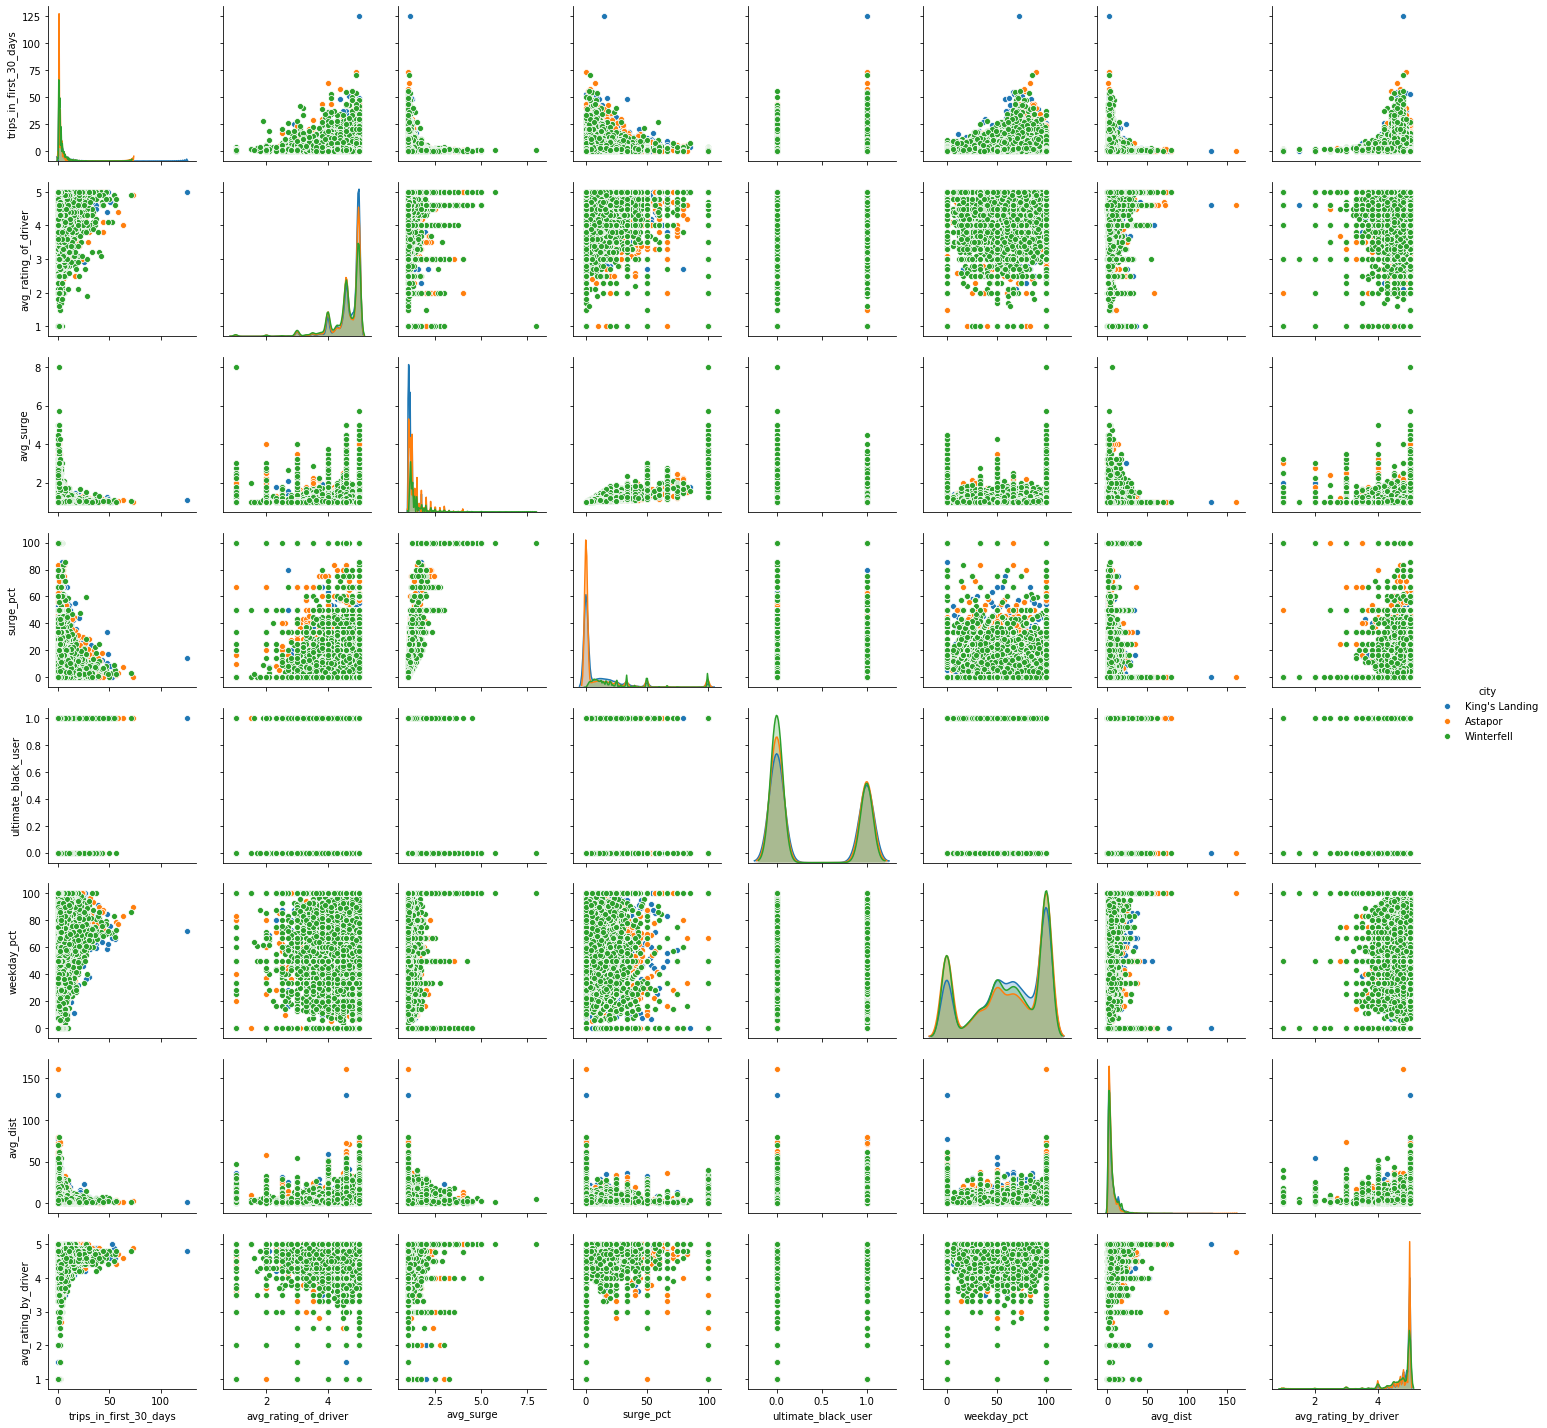

In [28]:
sns.pairplot(df, hue='city')

In [29]:
df.sort_values(by='last_trip_date').tail()

city  trips_in_first_30_days signup_date  \
45126      Winterfell                       1  2014-01-10   
38651  King's Landing                       0  2014-01-13   
14473  King's Landing                       0  2014-01-02   
22735      Winterfell                       0  2014-01-08   
45357         Astapor                       5  2014-01-28   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
45126                   4.6       1.02     2014-07-01  Android        6.3   
38651                   4.9       1.00     2014-07-01   iPhone        0.0   
14473                   5.0       1.00     2014-07-01  Android        0.0   
22735                   5.0       1.00     2014-07-01   iPhone        0.0   
45357                   4.4       1.02     2014-07-01   iPhone        1.4   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
45126                False         56.3      6.13                   4.6  
38651                 True         92.3     10.19                   5.0  
14473                False        100.0      5.06                   5.0  
22735                 True         75.0      8.71                   5.0  
45357                False         76.4      3.90                   4.9

In [31]:

frac = len(df[df['last_trip_date'] > '2014-06-01'])/len(df)
print('{:.2f}% driver retention rate'.format(frac*100))

36.62% driver retention rate



Looking at the tail end of the dataframe, the last trip date is '2014-07-01'. We consider drivers who took a trip remained active in the preceding 30 days, so this would mean we must observe last trip dates after '2014-06-01'. As we can see above, there is a 36.62% driver retention rate.

### Data Modeling 

In [33]:
# Create the target variable -- retained
df['retained'] = (df['last_trip_date'] > '2014-06-01')*1

In [34]:
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  retained  
0         46.2      3.67                   5.0         1  
1         50.0      8.26                   5.0         0  
2        100.0      0.77                   5.0         0  
3         80.0      2.36                   4.9         1  
4         82.4      3.13                   4.9         0

In [38]:

# Drop datetime features
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [39]:
# Creating dummy variables for categorical features
result = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [40]:
result.head()

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0                       4                   4.7       1.10       15.4   
1                       0                   5.0       1.00        0.0   
2                       3                   4.3       1.00        0.0   
3                       9                   4.6       1.14       20.0   
4                      14                   4.4       1.19       11.8   

   weekday_pct  avg_dist  avg_rating_by_driver  retained  city_King's Landing  \
0         46.2      3.67                   5.0         1                    1   
1         50.0      8.26                   5.0         0                    0   
2        100.0      0.77                   5.0         0                    0   
3         80.0      2.36                   4.9         1                    1   
4         82.4      3.13                   4.9         0                    0   

   city_Winterfell  phone_iPhone  ultimate_black_user_True  
0                0             1                         1  
1                0             0                         0  
2                0             1                         0  
3                0             1                         1  
4                1             0                         0

In [41]:
# split data into training and test sets 
X = result.drop('retained', axis=1)
y = result['retained']

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 11)
(10000, 11)
(40000,)
(10000,)


### Random Forest

Next we will use Random Forest Classifer. Random Forest is a popular machine learning method because it is flexible, robust, and has good feature selection. A forest is made up of many decision trees, the more trees it is comprised of, the more robust the forest is. Random Forest randomly selects these data trees and receives predictions from them. It then comprises the best answer in terms of voting

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

In [44]:
clf = RandomForestClassifier()
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.761875 0.7675   0.7625   0.76975  0.76575 ]
Average 5-Fold CV Score: 0.7654750000000001


As we can see above, Random Forest accuracy output is 75.5%

In [47]:
#fitted model 
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [49]:
# Generate classification report
print(classification_report(y_test, y_pred))
print('Test set accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6322
           1       0.68      0.65      0.66      3678

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.76      0.76      0.76     10000

Test set accuracy: 75.76%


In [50]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=range(0,2), columns=range(0,2))

0     1
0  5177  1145
1  1279  2399

Text(0.5, 1.0, 'ROC Curve')

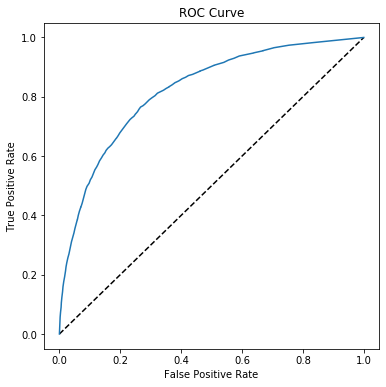

In [51]:
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [52]:
# Compute and print AUC score
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8214


Test accuracy: 75.76%

AUC: 0.7952

### Feature Selection 

In [53]:
fi = pd.DataFrame(list(zip(X.columns, rfc.feature_importances_)), columns = ['features', 'Importance'])
fi.sort_values(by='Importance', ascending=False).head(5)

features  Importance
5              avg_dist    0.296100
4           weekday_pct    0.129072
6  avg_rating_by_driver    0.114317
3             surge_pct    0.081984
1  avg_rating_of_driver    0.079817

Above we can see that the most important features are:

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● weekday_pct: the percent of the user’s trips occurring during a weekday

● avg_rating_by_driver: the rider’s average rating over all of their trips

<h1>Results & Conclusion:</h1> <br>
In order to increase rider retention, Ultimate needs to focus its time and resources on the most important features:

 1-Increase the desire and attractiveness for riders to acrease their average distance in the first 30 days after    signup

 2-Give higher incentive for customer service and ratings

 3-Increase user trips during the weekdays, so possibly making weekday trips higher pay in certain times, not just    weekends